# Описание проекта

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Исследование данных

### Изучение данных из файла

In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt 
import pylab
import seaborn as sns
from IPython.display import Markdown, display
import math
import numpy as np
import scipy as sp
from scipy import stats
from statsmodels.graphics.gofplots import qqplot

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

CALLS_FILE_PATH = 'calls.csv'
INTERNET_FILE_PATH = 'internet.csv'
MESSAGES_FILE_PATH = 'messages.csv'
TARIFFS_FILE_PATH = 'tariffs.csv'
USERS_FILE_PATH = 'users.csv'
K_Gb_to_Mb = 1024

def printmd(string):
    display(Markdown(string))
    
def read_file(file_path, sep_s, tab_desc):
    dataset = pd.read_csv(file_path, sep=sep_s)
    print()
    printmd("**" + tab_desc + "**")
    display(dataset.head(10))
    print('Всего строк в выборке:',dataset.shape[0])
    return dataset

calls_dataset = read_file(CALLS_FILE_PATH, ',', 'Информация о звонках')
internet_dataset = read_file(INTERNET_FILE_PATH, ',', 'Информация об интернет-сессиях')
messages_dataset = read_file(MESSAGES_FILE_PATH, ',', 'Информация о сообщениях')
tariffs_dataset = read_file(TARIFFS_FILE_PATH, ',', 'Информация о тарифах')
users_dataset = read_file(USERS_FILE_PATH, ',', 'Информация о пользователях')

**Информация о звонках**

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


Всего строк в выборке: 202607



**Информация об интернет-сессиях**

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


Всего строк в выборке: 149396



**Информация о сообщениях**

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


Всего строк в выборке: 123036



**Информация о тарифах**

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Всего строк в выборке: 2



**Информация о пользователях**

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


Всего строк в выборке: 500


### Описание данных

*Таблица users (информация о пользователях):*
    
    user_id — уникальный идентификатор пользователя
    first_name — имя пользователя
    last_name — фамилия пользователя
    age — возраст пользователя (годы)
    reg_date — дата подключения тарифа (день, месяц, год)
    churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
    city — город проживания пользователя
    tarif — название тарифного плана

*Таблица calls (информация о звонках):*

    id — уникальный номер звонка
    call_date — дата звонка
    duration — длительность звонка в минутах
    user_id — идентификатор пользователя, сделавшего звонок

*Таблица messages (информация о сообщениях):*
    
    id — уникальный номер сообщения 
    message_date — дата сообщения
    user_id — идентификатор пользователя, отправившего сообщение

*Таблица internet (информация об интернет-сессиях):*

    id — уникальный номер сессии
    mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
    session_date — дата интернет-сессии
    user_id — идентификатор пользователя

*Таблица tariffs (информация о тарифах):*

    tariff_name — название тарифа
    rub_monthly_fee — ежемесячная абонентская плата в рублях
    minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
    messages_included — количество сообщений в месяц, включённых в абонентскую плату
    mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
    rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
    rub_per_message — стоимость отправки сообщения сверх тарифного пакета
    rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


### Предобработка данных

#### Проверка и замена форматов, проверка пропусков

In [2]:
def get_dataset_desc(dataset, desc):
    printmd("**"+desc+"**")
    dataset.info()
    display(dataset.isna().sum().reset_index())
    display(dataset.head())

In [3]:
get_dataset_desc(calls_dataset, 'Звонки')
## Приведем call_date к формату даты, округлим потраченные минуты
calls_dataset['call_date'] = pd.to_datetime(calls_dataset['call_date'], format='%Y-%m-%d')
calls_dataset['duration'] = calls_dataset['duration'].apply(lambda x: math.ceil(x))

get_dataset_desc(internet_dataset, 'Интернет-сессии')
## Приведем session_date к формату даты
internet_dataset['session_date'] = pd.to_datetime(internet_dataset['session_date'], format='%Y-%m-%d')
internet_dataset.columns = ['for_delete', 'id', 'mb_used','session_date','user_id']
##
internet_dataset = internet_dataset.drop(['for_delete'], axis=1)

get_dataset_desc(messages_dataset, 'Сообщения')
## Приведем message_date к формату даты
messages_dataset['message_date'] = pd.to_datetime(messages_dataset['message_date'], format='%Y-%m-%d')

get_dataset_desc(tariffs_dataset, 'Тарифы')

get_dataset_desc(users_dataset, 'Пользователи')
## Приведем reg_date к формату даты
users_dataset['reg_date'] = pd.to_datetime(users_dataset['reg_date'], format='%Y-%m-%d')
## Приведем churn_date к формату даты
users_dataset['churn_date'] = pd.to_datetime(users_dataset['churn_date'], format='%Y-%m-%d')

**Звонки**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,index,0
0,id,0
1,call_date,0
2,duration,0
3,user_id,0


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


**Интернет-сессии**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,index,0
0,Unnamed: 0,0
1,id,0
2,mb_used,0
3,session_date,0
4,user_id,0


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


**Сообщения**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,index,0
0,id,0
1,message_date,0
2,user_id,0


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


**Тарифы**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,index,0
0,messages_included,0
1,mb_per_month_included,0
2,minutes_included,0
3,rub_monthly_fee,0
4,rub_per_gb,0
5,rub_per_message,0
6,rub_per_minute,0
7,tariff_name,0


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


**Пользователи**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,index,0
0,user_id,0
1,age,0
2,churn_date,462
3,city,0
4,first_name,0
5,last_name,0
6,reg_date,0
7,tariff,0


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Пропусков данных нет - чудеса.

Кроме *даты прекращения пользования тарифом* - если значение пропущено, то тариф ещё действовал на момент выгрузки данных

In [4]:
display(internet_dataset.head())

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [5]:
## Проведем замену верхнего регистра в текстовых полях на нижний и проверим данные на наличие дубликатов
users_columns = ['city', 'first_name', 'last_name', 'tariff']
for i in users_columns:
    users_dataset[i] = users_dataset[i].str.lower()

users_columns = ['city', 'first_name', 'last_name', 'tariff']
for i in users_columns:
    users_dataset[i] = users_dataset[i].str.lower()

In [6]:
printmd("**Количество дубликатов**")
print('Информация о звонках:', calls_dataset.duplicated().sum())
print('Информация об интернет-сессиях:', internet_dataset.duplicated().sum())
print('Информация о сообщениях:', messages_dataset.duplicated().sum())
print('Информация о тарифах:',tariffs_dataset.duplicated().sum())
print('Информация о пользователях:',users_dataset.duplicated().sum())

**Количество дубликатов**

Информация о звонках: 0
Информация об интернет-сессиях: 0
Информация о сообщениях: 0
Информация о тарифах: 0
Информация о пользователях: 0


### Поиск и исправление ошибок 

Ошибки, которые могут быть в данных:
* Нереальные значения в датах
* Ссылки на несуществующие строки в связанных таблицах (например, не существует указанный user_id)
* Нереальные значения возраста
* Нереальные значения объёма потраченного за сессию интернет-трафика
* Нереальная длительность звонков

calls_dataset['call_date'] 
calls_dataset['user_id'] 
calls_dataset['duration']

internet_dataset['session_date']
internet_dataset['user_id']
internet_dataset['mb_used']

messages_dataset['message_date']
messages_dataset['user_id']

users_dataset['reg_date']
users_dataset['churn_date'] 
users_dataset['age'] 

tarrifs_dataset['user_id']

In [7]:
printmd("**Звонки: дата**")
print(calls_dataset['call_date'].describe())

printmd("**Звонки: продолжительность**")
print(calls_dataset['duration'].describe())

printmd("**Интернет-сессии: дата**")
print(internet_dataset['session_date'].describe())

printmd("**Интернет-сессии: объем трафика**")
print(internet_dataset['mb_used'].describe())

printmd("**Сообщения: дата**")
print(messages_dataset['message_date'].describe())

printmd("**Пользователя: дата регистрации**")
print(users_dataset['reg_date'].describe())

printmd("**Пользователи: дата прекращения обслуживания**")
print(users_dataset['churn_date'].describe())

printmd("**Пользователи: возраст**")
print(users_dataset['age'].describe())



**Звонки: дата**

count                  202607
unique                    365
top       2018-12-31 00:00:00
freq                     1435
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: call_date, dtype: object


**Звонки: продолжительность**

count    202607.000000
mean          7.158198
std           5.959173
min           0.000000
25%           2.000000
50%           6.000000
75%          11.000000
max          38.000000
Name: duration, dtype: float64


**Интернет-сессии: дата**

count                  149396
unique                    365
top       2018-12-31 00:00:00
freq                     1057
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: session_date, dtype: object


**Интернет-сессии: объем трафика**

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64


**Сообщения: дата**

count                  123036
unique                    364
top       2018-12-31 00:00:00
freq                      859
first     2018-01-02 00:00:00
last      2018-12-31 00:00:00
Name: message_date, dtype: object


**Пользователя: дата регистрации**

count                     500
unique                    270
top       2018-05-28 00:00:00
freq                        8
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: reg_date, dtype: object


**Пользователи: дата прекращения обслуживания**

count                      38
unique                     33
top       2018-12-03 00:00:00
freq                        2
first     2018-08-17 00:00:00
last      2018-12-30 00:00:00
Name: churn_date, dtype: object


**Пользователи: возраст**

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64


На первый взгляд все хорошо

### Расчеты и добавление результатов  в таблицу

Посчитайте для каждого пользователя:
* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;

In [8]:
calls_dataset['month'] = pd.DatetimeIndex(calls_dataset['call_date']).month.astype('int64')
users_stat = pd.DataFrame(data={"month":[1,2,3,4,5,6,7,8,9,10,11,12]})\
    .assign(key=0)\
    .merge(users_dataset.assign(key=0),
           how='left', on = 'key')
users_stat = pd.merge(users_stat, calls_dataset.groupby(['user_id','month'], as_index=False)['duration']
                      .agg(['count','sum']).reset_index(),  
                      how='left', left_on=['user_id','month'], right_on = ['user_id','month'])

In [9]:
messages_dataset['month'] = pd.DatetimeIndex(messages_dataset['message_date']).month.astype('int64')
users_stat = pd.merge(users_stat, 
                      messages_dataset.groupby(['user_id','month'], as_index=False)['id'].agg(['count']).reset_index(),  
                      how='left', left_on=['user_id','month'], right_on = ['user_id','month'])

In [10]:
internet_dataset['month'] = pd.DatetimeIndex(internet_dataset['session_date']).month.astype('int64')
users_stat = pd.merge(users_stat, 
                      internet_dataset.groupby(['user_id','month'], as_index=False)['mb_used'].agg(['sum']).reset_index(),  
                      how='left', left_on=['user_id','month'], right_on = ['user_id','month'])

In [11]:
users_stat = users_stat.drop(['key'], axis=1)
users_stat.columns = ['month','user_id','age','churn_date','city','first_name','last_name','reg_date','tariff', 'calls_cnt',
                         'calls_duration_sum', 'messages_cnt', 'mb_used_sum']

users_stat['mb_used_sum'] = users_stat['mb_used_sum'] / K_Gb_to_Mb

columns = ['calls_cnt', 'calls_duration_sum', 'messages_cnt', 'mb_used_sum']
for column in columns:
    users_stat[column] = users_stat[column].fillna(0)

users_stat['mb_used_sum'] = users_stat['mb_used_sum'].apply(lambda x: math.ceil(x))

users_stat.columns = ['month','user_id','age','churn_date','city','first_name','last_name','reg_date','tariff', 'calls_cnt',
                         'calls_duration_sum', 'messages_cnt', 'gb_used_sum']

display(users_stat.query('user_id == 1000').head(12))
display(users_stat.head())

,month,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,calls_cnt,calls_duration_sum,messages_cnt,gb_used_sum
0,1,1000,52,NaT,краснодар,рафаил,верещагин,2018-05-25,ultra,0.0,0.0,0.0,0
500,2,1000,52,NaT,краснодар,рафаил,верещагин,2018-05-25,ultra,0.0,0.0,0.0,0
1000,3,1000,52,NaT,краснодар,рафаил,верещагин,2018-05-25,ultra,0.0,0.0,0.0,0
1500,4,1000,52,NaT,краснодар,рафаил,верещагин,2018-05-25,ultra,0.0,0.0,0.0,0
2000,5,1000,52,NaT,краснодар,рафаил,верещагин,2018-05-25,ultra,22.0,159.0,22.0,3
2500,6,1000,52,NaT,краснодар,рафаил,верещагин,2018-05-25,ultra,43.0,172.0,60.0,23
3000,7,1000,52,NaT,краснодар,рафаил,верещагин,2018-05-25,ultra,47.0,340.0,75.0,14
3500,8,1000,52,NaT,краснодар,рафаил,верещагин,2018-05-25,ultra,52.0,408.0,81.0,14
4000,9,1000,52,NaT,краснодар,рафаил,верещагин,2018-05-25,ultra,58.0,466.0,57.0,15
4500,10,1000,52,NaT,краснодар,рафаил,верещагин,2018-05-25,ultra,57.0,350.0,73.0,15


,month,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,calls_cnt,calls_duration_sum,messages_cnt,gb_used_sum
0,1,1000,52,NaT,краснодар,рафаил,верещагин,2018-05-25,ultra,0.0,0.0,0.0,0
1,1,1001,41,NaT,москва,иван,ежов,2018-11-01,smart,0.0,0.0,0.0,0
2,1,1002,59,NaT,стерлитамак,евгений,абрамович,2018-06-17,smart,0.0,0.0,0.0,0
3,1,1003,23,NaT,москва,белла,белякова,2018-08-17,ultra,0.0,0.0,0.0,0
4,1,1004,68,NaT,новокузнецк,татьяна,авдеенко,2018-05-14,ultra,0.0,0.0,0.0,0


Посчитайте для каждого пользователя:
* помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [12]:
display(tariffs_dataset.head())

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [13]:
def getMonthSum(row):
    r = tariffs_dataset.loc[tariffs_dataset['tariff_name'] == row['tariff']]
    res_call = (row['calls_duration_sum'] - r.iloc[0]['minutes_included'])*r.iloc[0]['rub_per_minute']
    res_msg = (row['messages_cnt'] - r.iloc[0]['messages_included'])*r.iloc[0]['rub_per_message']
    res_int = (row['gb_used_sum'] - (r.iloc[0]['mb_per_month_included'] / K_Gb_to_Mb))*r.iloc[0]['rub_per_gb']
    res = 0
    if  row['reg_date'].month <= row['month']:
        if res_call > 0:
            res += res_call
        if res_msg > 0:
            res += res_msg
        if res_int > 0:
            res += res_int
        res += r.iloc[0]['rub_monthly_fee']
    return res 

def getMonthSumCall(row):
    r = tariffs_dataset.loc[tariffs_dataset['tariff_name'] == row['tariff']]
    res_call = (row['calls_duration_sum'] - r.iloc[0]['minutes_included'])*r.iloc[0]['rub_per_minute']
    res = 0
    if  row['reg_date'].month <= row['month']:
        if res_call > 0:
            res += res_call
    return res 

def getMonthSumMsg(row):
    r = tariffs_dataset.loc[tariffs_dataset['tariff_name'] == row['tariff']]
    res_msg = (row['messages_cnt'] - r.iloc[0]['messages_included'])*r.iloc[0]['rub_per_message']
    res = 0
    if  row['reg_date'].month <= row['month']:
        if res_msg > 0:
            res += res_msg
    return res 

def getMonthSumGb(row):
    r = tariffs_dataset.loc[tariffs_dataset['tariff_name'] == row['tariff']]
    res_int = (row['gb_used_sum'] - (r.iloc[0]['mb_per_month_included'] / K_Gb_to_Mb))*r.iloc[0]['rub_per_gb']
    res = 0
    if  row['reg_date'].month <= row['month']:
        if res_int > 0:
            res += res_int
    return res 

users_stat['pay_sum'] = users_stat.apply(getMonthSum, axis = 1)
users_stat['pay_over_call'] = users_stat.apply(getMonthSumCall, axis = 1)
users_stat['pay_over_msg'] = users_stat.apply(getMonthSumMsg, axis = 1)
users_stat['pay_over_gb'] = users_stat.apply(getMonthSumGb, axis = 1)

display(users_stat.query('user_id == 1000').head(12))

,month,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,calls_cnt,calls_duration_sum,messages_cnt,gb_used_sum,pay_sum,pay_over_call,pay_over_msg,pay_over_gb
0,1,1000,52,NaT,краснодар,рафаил,верещагин,2018-05-25,ultra,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
500,2,1000,52,NaT,краснодар,рафаил,верещагин,2018-05-25,ultra,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
1000,3,1000,52,NaT,краснодар,рафаил,верещагин,2018-05-25,ultra,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
1500,4,1000,52,NaT,краснодар,рафаил,верещагин,2018-05-25,ultra,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2000,5,1000,52,NaT,краснодар,рафаил,верещагин,2018-05-25,ultra,22.0,159.0,22.0,3,1950.0,0.0,0.0,0.0
2500,6,1000,52,NaT,краснодар,рафаил,верещагин,2018-05-25,ultra,43.0,172.0,60.0,23,1950.0,0.0,0.0,0.0
3000,7,1000,52,NaT,краснодар,рафаил,верещагин,2018-05-25,ultra,47.0,340.0,75.0,14,1950.0,0.0,0.0,0.0
3500,8,1000,52,NaT,краснодар,рафаил,верещагин,2018-05-25,ultra,52.0,408.0,81.0,14,1950.0,0.0,0.0,0.0
4000,9,1000,52,NaT,краснодар,рафаил,верещагин,2018-05-25,ultra,58.0,466.0,57.0,15,1950.0,0.0,0.0,0.0
4500,10,1000,52,NaT,краснодар,рафаил,верещагин,2018-05-25,ultra,57.0,350.0,73.0,15,1950.0,0.0,0.0,0.0


In [14]:
users_stat = users_stat.loc[users_stat['pay_sum'] != 0]

## Анализ данных 

Опишите поведение клиентов оператора, исходя из выборки. 
Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 
Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

In [15]:
users_stat['tariff_id'] = users_stat['tariff'].apply(lambda x: 1 if x == 'smart' else 2)

def printPieHist(data, title, columnx, columny, filtres, over, data_dict, column_dict, column_dict_val):
    printmd("**все**")
    print(data[columny].describe())
    print('Дисперсия:', np.var(data[columny]))
    print('Медиана:', data[columny].median())

    qqplot(data[columny], line='s')
    plt.title("График квантиль-квантиль " + title)
    plt.show()
        
    for elem in data[columnx].unique():
        print()
        printmd("**" + elem + "**")
        print(data[data[columnx] == elem][columny].describe())
        print('Дисперсия:', np.var(data[data[columnx] == elem][columny]))
        print('Медиана:', data[data[columnx] == elem][columny].median())
    
    data.groupby(columnx)[columny].sum().plot(y=columny, kind='pie', autopct='%1.1f%%')
    plt.title(title)
    plt.show()
    
    data.groupby(columnx)[columny].hist(alpha = 0.75)
    plt.title(title)
    plt.show()
    
    if over == 1:
        printmd("**Превышение**")
        data_over = pd.merge(data, data_dict, how='left', left_on=[columnx], right_on = [column_dict])
        data_over['over'] = data_over[columny] - data_over[column_dict_val]
        data_over = data_over[data_over['over'] > 0]
        print('Превышение в', data_over.shape[0], 'из', data.shape[0],'(', round(100*(data_over.shape[0]/data.shape[0]),0),'% от общего количества оплат)')
        print(data_over['over'].describe())
        
        data_over.groupby(columnx)['over'].hist(alpha = 0.75)
        plt.title(title + ": " + "превышение")
        plt.show()
        for elem in data[columnx].unique():
            print()
            printmd("**" + elem + "**")
            print('Превышение в', data_over[data_over[columnx] == elem].shape[0], 'из', data.shape[0],'(', round(100*(data_over[data_over[columnx] == elem].shape[0]/data.shape[0]),0),'% от общего количества оплат)')
            print(data_over[data_over[columnx] == elem]['over'].describe())
            print('Дисперсия:', np.var(data_over[data_over[columnx] == elem]['over']))
            print('Медиана:', data_over[data_over[columnx] == elem]['over'].median())
            qqplot(data_over[data_over[columnx] == elem]['over'], line='s')
            plt.title("График квантиль-квантиль " + title + " " + elem + ": превышение")
            plt.show()
            #stat, p = stats.shapiro(data_over[data_over[columnx] == elem]['over'])
            #print('Тест Шапиро-Вилка:', stat, p)
            #if p >= .05:
            #    print('Нельзя утверждать, что анализируемое распределение не отличается от нормального')
            #else:
            #   print('Можно утверждать, что анализируемое распределение отличается от нормального')

           
        
def normalCheck(data, column, alpha, title):
    printmd("**"+title+"**")
    qqplot(data[column], line='s')
    plt.show()
    #Тест Шапиро-Вилка
    stat, p = stats.shapiro(data[column])
    print('Тест Шапиро-Вилка:', stat, p)
    #if p >= alpha:
    #    print('Нельзя утверждать, что анализируемое распределение не отличается от нормального')
    #else:
    #    print('Можно утверждать, что анализируемое распределение отличается от нормального')

    #Тест д'Агостино на K ^ 2
    stat, p = stats.normaltest(data[column])
    print('Тест дАгостино на K ^ 2:', stat, p)

    #Тест Андерсона-Дарлинга
    stat = stats.anderson(data[column])
    print('Тест Андерсона-Дарлинга:', stat)

### Суммы оплат по тарифам 

**все**

count    3259.000000
mean     1524.578398
std       797.863935
min       550.000000
25%       750.000000
50%      1651.000000
75%      1950.000000
max      6770.000000
Name: pay_sum, dtype: float64
Дисперсия: 636391.5264557452
Медиана: 1651.0


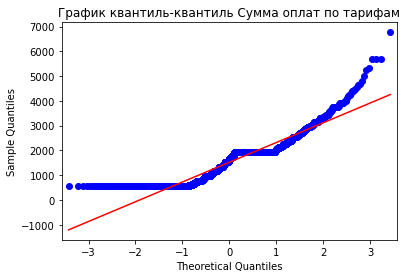

**smart**

count    2253.000000
mean     1282.090990
std       817.570163
min       550.000000
25%       550.000000
50%      1009.000000
75%      1750.000000
max      6770.000000
Name: pay_sum, dtype: float64
Дисперсия: 668124.2913213979
Медиана: 1009.0



**ultra**

count    1006.000000
mean     2067.644135
std       372.632582
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: pay_sum, dtype: float64
Дисперсия: 138717.0145133155
Медиана: 1950.0


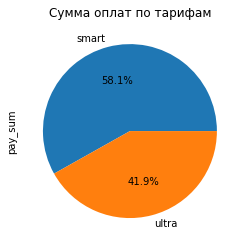

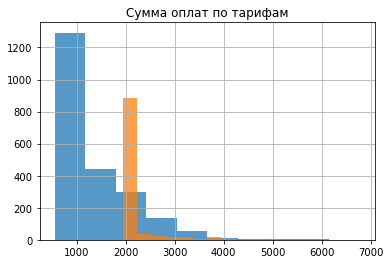

**Превышение**

Превышение в 1796 из 3259 ( 55.0 % от общего количества оплат)
count    1796.000000
mean      984.271158
std       792.134669
min         3.000000
25%       400.000000
50%       800.000000
75%      1400.000000
max      6220.000000
Name: over, dtype: float64


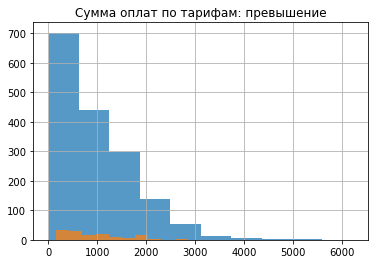

**smart**

Превышение в 1662 из 3259 ( 51.0 % от общего количества оплат)
count    1662.000000
mean      992.419374
std       804.823706
min         3.000000
25%       400.000000
50%       800.000000
75%      1403.250000
max      6220.000000
Name: over, dtype: float64
Дисперсия: 647351.4625127246
Медиана: 800.0


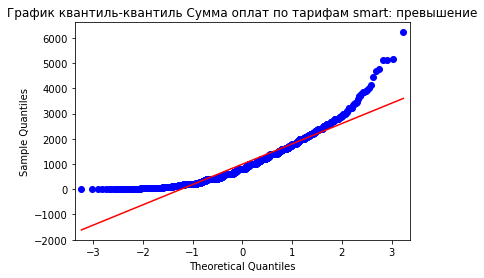

**ultra**

Превышение в 134 из 3259 ( 4.0 % от общего количества оплат)
count     134.000000
mean      883.208955
std       606.634498
min       150.000000
25%       450.000000
50%       750.000000
75%      1312.500000
max      2850.000000
Name: over, dtype: float64
Дисперсия: 365259.10559144604
Медиана: 750.0


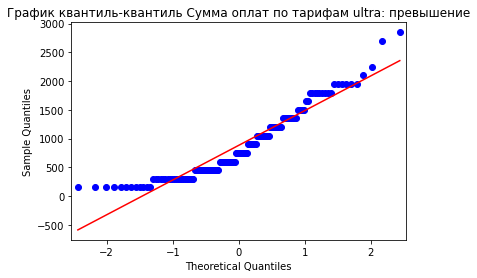

In [16]:
printPieHist(users_stat, 'Сумма оплат по тарифам', 'tariff', 'pay_sum',[], 1, \
             tariffs_dataset, 'tariff_name', 'rub_monthly_fee')

**Вывод**

58.1% приносят пользователи тарифа SMART, при этом можно обратить внимание на то, что в 51% случаев оплат пользователи этого тарифа платят сумму, превышающую сумму ежемесячного платежа, за счет превышения лимитов тарифа.

Тип распределения - как определить? Оно не похоже на нормальное.

**все**

count    3259.000000
mean       62.168457
std        33.816101
min         0.000000
25%        39.000000
50%        62.000000
75%        82.000000
max       244.000000
Name: calls_cnt, dtype: float64
Дисперсия: 1143.1778206003737
Медиана: 62.0


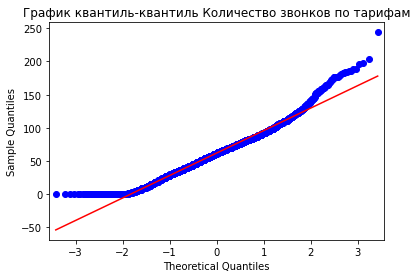

**smart**

count    2253.000000
mean       57.840657
std        26.490437
min         0.000000
25%        39.000000
50%        59.000000
75%        76.000000
max       198.000000
Name: calls_cnt, dtype: float64
Дисперсия: 701.4317779972394
Медиана: 59.0



**ultra**

count    1006.000000
mean       71.860835
std        44.705632
min         0.000000
25%        38.000000
50%        72.000000
75%       102.000000
max       244.000000
Name: calls_cnt, dtype: float64
Дисперсия: 1996.6068756447444
Медиана: 72.0


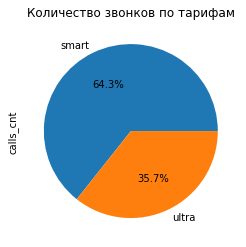

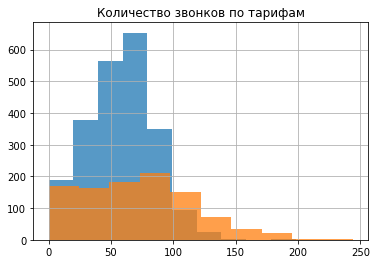

In [17]:
printPieHist(users_stat, 'Количество звонков по тарифам', 'tariff', 'calls_cnt', [], 0, 0, 0, 0)

**все**

count    3259.000000
mean      445.014115
std       245.938545
min         0.000000
25%       277.000000
50%       439.000000
75%       586.000000
max      1673.000000
Name: calls_duration_sum, dtype: float64
Дисперсия: 60467.20814689213
Медиана: 439.0


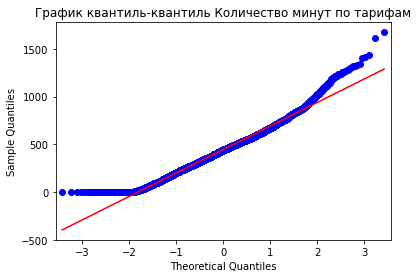

**smart**

count    2253.000000
mean      413.482912
std       194.100433
min         0.000000
25%       279.000000
50%       419.000000
75%       544.000000
max      1435.000000
Name: calls_duration_sum, dtype: float64
Дисперсия: 37658.255921926044
Медиана: 419.0



**ultra**

count    1006.000000
mean      515.630219
std       323.171560
min         0.000000
25%       272.000000
50%       508.000000
75%       749.250000
max      1673.000000
Name: calls_duration_sum, dtype: float64
Дисперсия: 104336.04020015095
Медиана: 508.0


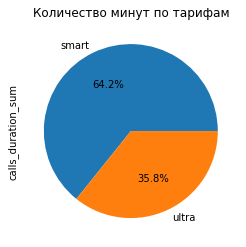

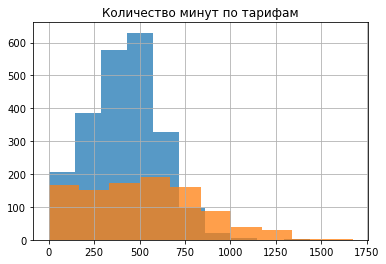

**Превышение**

Превышение в 754 из 3259 ( 23.0 % от общего количества оплат)
count    754.000000
mean     122.996021
std      105.793184
min        1.000000
25%       44.000000
50%      100.000000
75%      172.000000
max      935.000000
Name: over, dtype: float64


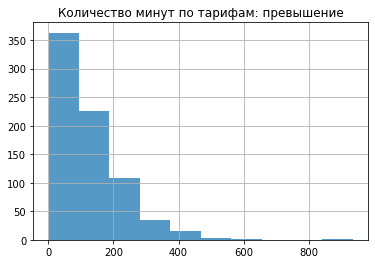

**smart**

Превышение в 754 из 3259 ( 23.0 % от общего количества оплат)
count    754.000000
mean     122.996021
std      105.793184
min        1.000000
25%       44.000000
50%      100.000000
75%      172.000000
max      935.000000
Name: over, dtype: float64
Дисперсия: 11177.354095575143
Медиана: 100.0


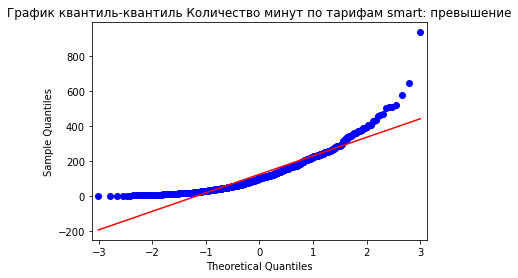

**ultra**

Превышение в 0 из 3259 ( 0.0 % от общего количества оплат)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: over, dtype: float64
Дисперсия: nan
Медиана: nan


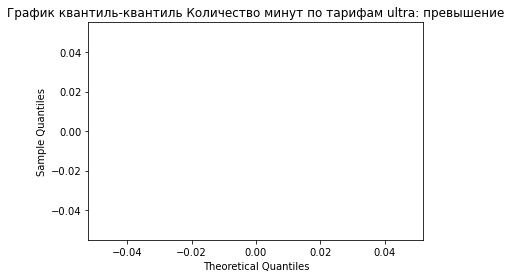

In [18]:
printPieHist(users_stat, 'Количество минут по тарифам', 'tariff', 'calls_duration_sum',\
             [],1, tariffs_dataset, 'tariff_name', 'minutes_included')

**все**

count    3259.000000
mean       85.368825
std       217.946509
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      2805.000000
Name: pay_over_call, dtype: float64
Дисперсия: 47486.10576023401
Медиана: 0.0


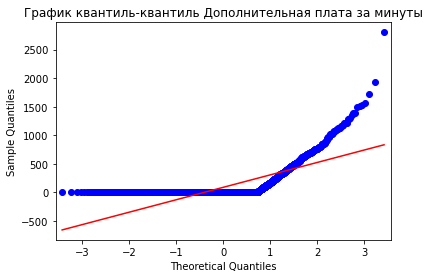

**smart**

count    2253.000000
mean      123.487350
std       253.003272
min         0.000000
25%         0.000000
50%         0.000000
75%       132.000000
max      2805.000000
Name: pay_over_call, dtype: float64
Дисперсия: 63982.24451375005
Медиана: 0.0



**ultra**

count    1006.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: pay_over_call, dtype: float64
Дисперсия: 0.0
Медиана: 0.0


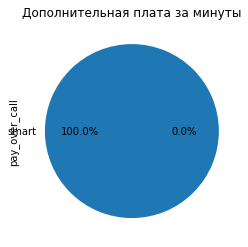

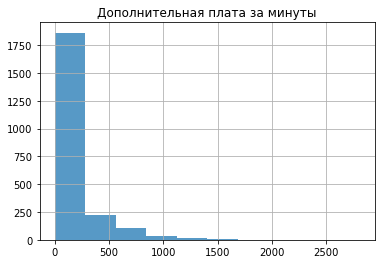

In [19]:
printPieHist(users_stat, 'Дополнительная плата за минуты', 'tariff', 'pay_over_call',[],0, 0, 0, 0)

**Вывод**

Пользователи тарифа ULTRA совершают больше звонков в расчете на одного пользователя и расчетный месяц, также звонки длятся дольше. Стоит обратить внимание на то, что пользователи тарифа ULTRA укладываются в пределы тарифа, в отличии от пользователей тарифа SMART.

**все**

count    3259.000000
mean       37.752685
std        36.174780
min         0.000000
25%         8.000000
50%        29.000000
75%        56.000000
max       224.000000
Name: messages_cnt, dtype: float64
Дисперсия: 1308.2131525030163
Медиана: 29.0


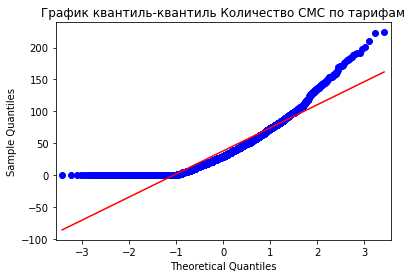

**smart**

count    2253.000000
mean       33.028407
std        28.285544
min         0.000000
25%         9.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: messages_cnt, dtype: float64
Дисперсия: 799.7169027872167
Медиана: 28.0



**ultra**

count    1006.000000
mean       48.333002
std        47.826442
min         0.000000
25%         5.000000
50%        37.000000
75%        78.000000
max       224.000000
Name: messages_cnt, dtype: float64
Дисперсия: 2285.0948750834914
Медиана: 37.0


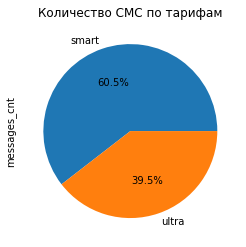

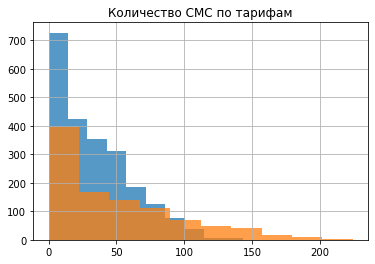

**Превышение**

Превышение в 564 из 3259 ( 17.0 % от общего количества оплат)
count    564.000000
mean      22.921986
std       17.942308
min        1.000000
25%        9.000000
50%       18.500000
75%       33.000000
max       93.000000
Name: over, dtype: float64


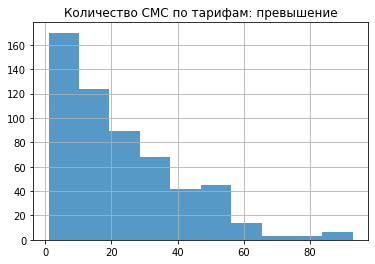

**smart**

Превышение в 564 из 3259 ( 17.0 % от общего количества оплат)
count    564.000000
mean      22.921986
std       17.942308
min        1.000000
25%        9.000000
50%       18.500000
75%       33.000000
max       93.000000
Name: over, dtype: float64
Дисперсия: 321.3556159146929
Медиана: 18.5


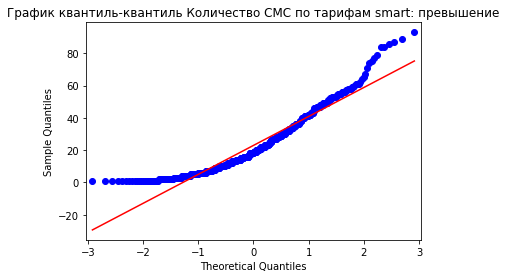

**ultra**

Превышение в 0 из 3259 ( 0.0 % от общего количества оплат)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: over, dtype: float64
Дисперсия: nan
Медиана: nan


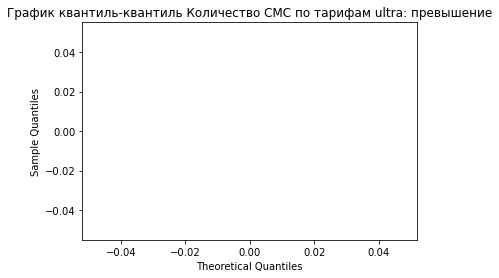

In [20]:
printPieHist(users_stat, 'Количество СМС по тарифам', 'tariff', 'messages_cnt',[],1,\
             tariffs_dataset, 'tariff_name', 'messages_included')

**все**

count    3259.000000
mean       11.900583
std        34.316387
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       279.000000
Name: pay_over_msg, dtype: float64
Дисперсия: 1177.2530803597488
Медиана: 0.0


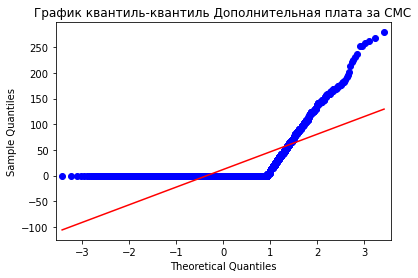

**smart**

count    2253.000000
mean       17.214381
std        40.151674
min         0.000000
25%         0.000000
50%         0.000000
75%         3.000000
max       279.000000
Name: pay_over_msg, dtype: float64
Дисперсия: 1611.441391061381
Медиана: 0.0



**ultra**

count    1006.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: pay_over_msg, dtype: float64
Дисперсия: 0.0
Медиана: 0.0


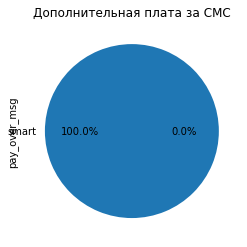

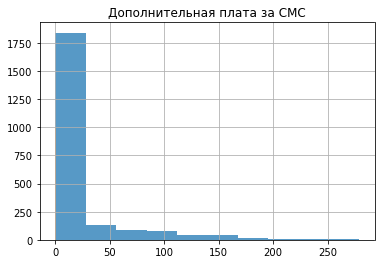

In [21]:
printPieHist(users_stat, 'Дополнительная плата за СМС', 'tariff', 'pay_over_msg',[],0, 0, 0, 0)

In [22]:
print(users_stat[users_stat['pay_over_msg'] > 0]['pay_over_msg'].sum(),
      users_stat[users_stat['pay_over_msg'] > 0]['pay_over_msg'].count())

38784.0 564


**Вывод**

Пользователи тарифа ULTRA не выходят за рамки тарифа по количеству отправленных СМСв отличии от пользователей тарифа SMART - в 17.0% от общего количества оплат пользователи тарифа SMART доплачивают за СМС.

**все**

count    3259.000000
mean       17.060141
std         7.621579
min         0.000000
25%        12.000000
50%        17.000000
75%        21.000000
max        49.000000
Name: gb_used_sum, dtype: float64
Дисперсия: 58.070638949086515
Медиана: 17.0


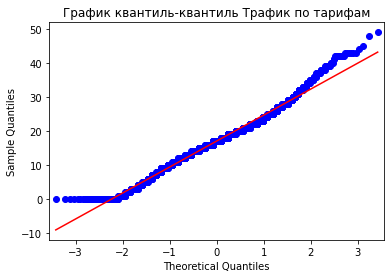

**smart**

count    2253.000000
mean       16.154905
std         5.957179
min         0.000000
25%        13.000000
50%        17.000000
75%        20.000000
max        38.000000
Name: gb_used_sum, dtype: float64
Дисперсия: 35.47223182622385
Медиана: 17.0



**ultra**

count    1006.000000
mean       19.087475
std        10.140913
min         0.000000
25%        12.000000
50%        19.000000
75%        27.000000
max        49.000000
Name: gb_used_sum, dtype: float64
Дисперсия: 102.73588686568465
Медиана: 19.0


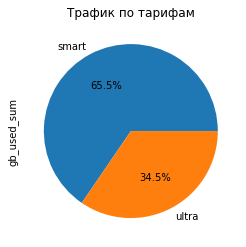

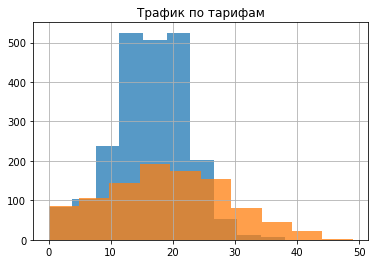

**Превышение**

Превышение в 1438 из 3259 ( 44.0 % от общего количества оплат)
count    1438.000000
mean        5.181502
std         3.572845
min         1.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        23.000000
Name: over, dtype: float64


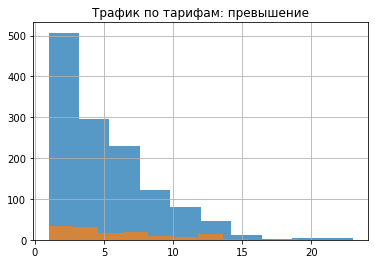

**smart**

Превышение в 1304 из 3259 ( 40.0 % от общего количества оплат)
count    1304.000000
mean        5.108896
std         3.514528
min         1.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        23.000000
Name: over, dtype: float64
Дисперсия: 12.34243620384658
Медиана: 4.0


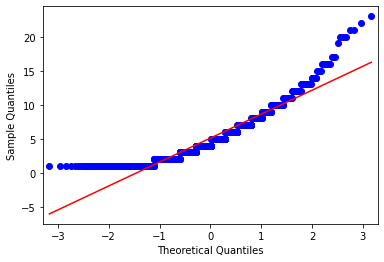

**ultra**

Превышение в 134 из 3259 ( 4.0 % от общего количества оплат)
count    134.00000
mean       5.88806
std        4.04423
min        1.00000
25%        3.00000
50%        5.00000
75%        8.75000
max       19.00000
Name: over, dtype: float64
Дисперсия: 16.233738026286463
Медиана: 5.0


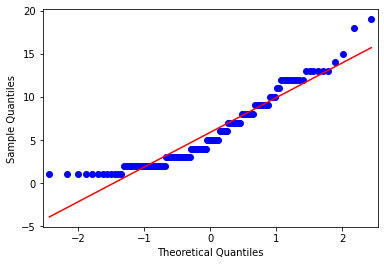

In [23]:
printPieHist(users_stat, 'Трафик по тарифам', 'tariff', 'gb_used_sum',[],0, 0, 0, 0)
printmd("**Превышение**")

data_over = pd.merge(users_stat, tariffs_dataset, how='left', left_on=['tariff'], right_on = ['tariff_name'])
data_over['over'] = data_over['gb_used_sum'] - data_over['mb_per_month_included'] / K_Gb_to_Mb
data_over = data_over[data_over['over'] > 0]
print('Превышение в', data_over.shape[0], 'из', users_stat.shape[0],'(', \
      round(100*(data_over.shape[0]/users_stat.shape[0]),0),'% от общего количества оплат)')
print(data_over['over'].describe())
plt.title('Трафик по тарифам: превышение')
data_over.groupby('tariff')['over'].hist(alpha = 0.75)
plt.show()
for elem in tariffs_dataset['tariff_name'].unique():
    print()
    printmd("**" + elem + "**")
    print('Превышение в', data_over[data_over['tariff'] == elem].shape[0], 'из',\
          users_stat.shape[0],'(', round(100*(data_over[data_over['tariff'] == elem].shape[0]/users_stat.shape[0]),0),\
          '% от общего количества оплат)')
    print(data_over[data_over['tariff'] == elem]['over'].describe())
    print('Дисперсия:', np.var(data_over[data_over['tariff'] == elem]['over']))
    print('Медиана:', data_over[data_over['tariff'] == elem]['over'].median())
    qqplot(data_over[data_over['tariff'] == elem]['over'], line='s')
    plt.show()

**все**

count    3259.000000
mean      445.151887
std       681.435941
min         0.000000
25%         0.000000
50%         0.000000
75%       800.000000
max      4600.000000
Name: pay_over_gb, dtype: float64
Дисперсия: 464212.4577526485
Медиана: 0.0


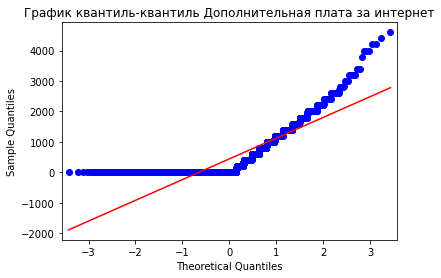

**smart**

count    2253.000000
mean      591.389259
std       735.195190
min         0.000000
25%         0.000000
50%       400.000000
75%      1000.000000
max      4600.000000
Name: pay_over_gb, dtype: float64
Дисперсия: 540272.0601953163
Медиана: 400.0



**ultra**

count    1006.000000
mean      117.644135
std       372.632582
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      2850.000000
Name: pay_over_gb, dtype: float64
Дисперсия: 138717.01451331546
Медиана: 0.0


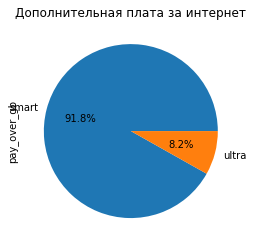

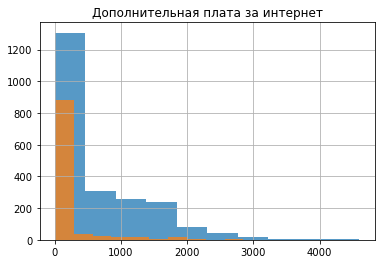

In [24]:
printPieHist(users_stat, 'Дополнительная плата за интернет', 'tariff', 'pay_over_gb',[],0, 0, 0, 0)

**Вывод**

Пользователи тарифа ULTRA редко выходят за рамки тарифа по объему трафика, в отличии от пользователей тарифа SMART - в 40.0% от общего количества оплат пользователи тарифа SMART доплачивают объем использованного трафика.

### Поведение пользователей 

Посмотрим суммы и среднее по тарифам

In [25]:
tariff_pivot_overpay = users_stat.groupby('tariff')['pay_sum','pay_over_call','pay_over_msg', 'pay_over_gb'].agg(['sum']).reset_index()
tariff_pivot_overpay['tariff_sum'] = tariff_pivot_overpay['pay_sum'] - tariff_pivot_overpay['pay_over_call'] - tariff_pivot_overpay['pay_over_msg'] - tariff_pivot_overpay['pay_over_gb']
tariff_pivot_overpay.columns = ['Тариф','Сумма оплат','Доп плата за звонки','Доп плата за СМС','Доп плата за Гб', 'Оплата по тарифу']

tariff_pivot_cnt = users_stat.groupby('tariff')['calls_cnt','calls_duration_sum','messages_cnt', 'gb_used_sum'].agg(['sum']).reset_index()
tariff_pivot_cnt.columns = ['Тариф','Количество звонков','Длительность звонков','Количество СМС', 'Количество Гб']

tariff_users_cnt = users_dataset.groupby('tariff')['user_id'].count().reset_index()
tariff_users_cnt.columns = ['Тариф','Количество пользователей']

tariff_pivot_overpay_mean = users_stat.groupby('tariff')['pay_sum','pay_over_call','pay_over_msg', 'pay_over_gb'].agg(['mean']).reset_index()
tariff_pivot_overpay_mean['tariff_sum'] = tariff_pivot_overpay_mean['pay_sum'] - tariff_pivot_overpay_mean['pay_over_call'] - tariff_pivot_overpay_mean['pay_over_msg'] - tariff_pivot_overpay_mean['pay_over_gb']
tariff_pivot_overpay_mean.columns = ['Тариф','Средняя сумма оплат','Доп плата за звонки','Доп плата за СМС','Доп плата за Гб', 'Оплата по тарифу']

tariff_pivot_cnt_mean = users_stat.groupby('tariff')['calls_cnt','calls_duration_sum','messages_cnt', 'gb_used_sum'].agg(['mean']).reset_index()
tariff_pivot_cnt_mean.columns = ['Тариф','Количество звонков','Длительность звонков','Количество СМС', 'Количество Гб']

printmd("**Суммы по тарифам**")
display(tariff_pivot_cnt)
display(tariff_pivot_overpay)
print()
print()
printmd("**Среднее по тарифам**")
display(tariff_pivot_cnt_mean)
display(tariff_pivot_overpay_mean)
print()
print()
printmd("**Количество пользоваттелей по тарифам**")
display(tariff_users_cnt)

**Суммы по тарифам**

,Тариф,Количество звонков,Длительность звонков,Количество СМС,Количество Гб
0,smart,130315.0,931577.0,74413.0,36397
1,ultra,72292.0,518724.0,48623.0,19202


,Тариф,Сумма оплат,Доп плата за звонки,Доп плата за СМС,Доп плата за Гб,Оплата по тарифу
0,smart,2888551.0,278217.0,38784.0,1332400.0,1239150.0
1,ultra,2080050.0,0.0,0.0,118350.0,1961700.0


**Среднее по тарифам**

,Тариф,Количество звонков,Длительность звонков,Количество СМС,Количество Гб
0,smart,57.840657,413.482912,33.028407,16.154905
1,ultra,71.860835,515.630219,48.333002,19.087475


,Тариф,Средняя сумма оплат,Доп плата за звонки,Доп плата за СМС,Доп плата за Гб,Оплата по тарифу
0,smart,1282.090990,123.48735,17.214381,591.389259,550.0
1,ultra,2067.644135,0.00000,0.000000,117.644135,1950.0


**Количество пользоваттелей по тарифам**

,Тариф,Количество пользователей
0,smart,351
1,ultra,149


Посмотрим более подробно поведение пользователей тарифа SMART в разбивке по месяцам. Не теряют ли они интерес к тарифу? Сколько новых пользователей подключается? К каким тарифам? Не идет ли на спад доплата по превышению лимитов?

In [26]:
#так как вре регистрации в 2018, обрабатывать год не будем, а так была бы еще одна категория - пользователи, зарегистрировавшиеся до 2018
users_dataset['month_reg'] = pd.DatetimeIndex(users_dataset['reg_date']).month.astype('int64')
users_dataset['month_churn'] = pd.DatetimeIndex(users_dataset['churn_date']).month#.astype('int64', errors = 'ignore')

В среднем в месяц на тариф SMART подключается 29.2 пользователей


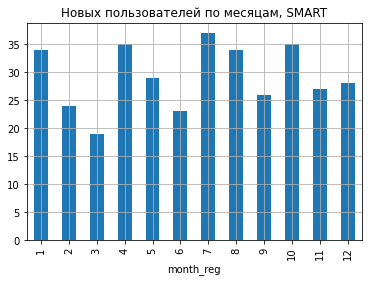

В среднем в месяц на тариф ULTRA подключается 12.4 пользователей


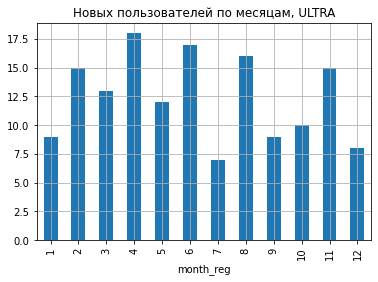

В среднем в месяц от тарифа SMART отключается 4.6 пользователей
В среднем в месяц от тарифа ULTRA отключается 3.0 пользователей


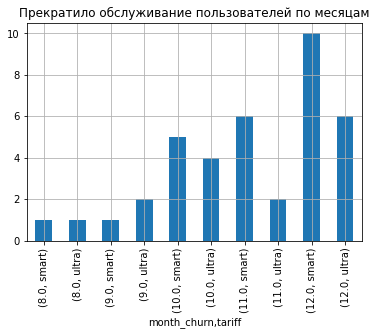

In [27]:
print('В среднем в месяц на тариф SMART подключается', 
      round(users_dataset[users_dataset['tariff'] == 'smart'].groupby('month_reg')['user_id'].count().mean(),1),
      'пользователей')

users_dataset[users_dataset['tariff'] == 'smart'].groupby('month_reg')['user_id'].count().plot(y='user_id', kind='bar')
plt.title('Новых пользователей по месяцам, SMART')
plt.grid()
plt.show()

print('В среднем в месяц на тариф ULTRA подключается', 
      round(users_dataset[users_dataset['tariff'] == 'ultra'].groupby('month_reg')['user_id'].count().mean(),1),
      'пользователей')

users_dataset[users_dataset['tariff'] == 'ultra'].groupby('month_reg')['user_id'].count().plot(y='user_id', kind='bar')
plt.title('Новых пользователей по месяцам, ULTRA')
plt.grid()
plt.show()


print('В среднем в месяц от тарифа SMART отключается', 
      round(users_dataset[users_dataset['tariff'] == 'smart'].groupby('month_churn')['user_id'].count().mean(),1),
      'пользователей')

print('В среднем в месяц от тарифа ULTRA отключается', 
      round(users_dataset[users_dataset['tariff'] == 'ultra'].groupby('month_churn')['user_id'].count().mean(),1),
      'пользователей')

users_dataset.groupby(['month_churn','tariff'])['user_id'].count().plot(y='user_id', kind='bar')
plt.title('Прекратило обслуживание пользователей по месяцам')
plt.grid()
plt.show()

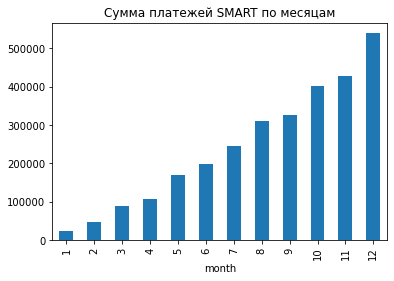

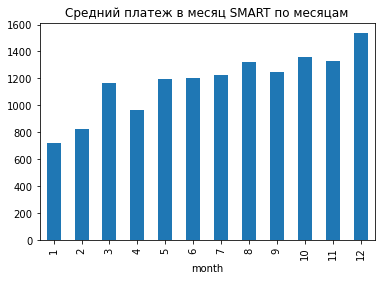

In [28]:
users_stat[users_stat['tariff'] == 'smart'].groupby('month')['pay_sum'].sum().plot(y='pay_sum', kind='bar')
plt.title('Сумма платежей SMART по месяцам')
plt.show()
users_stat[users_stat['tariff'] == 'smart'].groupby('month')['pay_sum']. mean().plot(y='pay_sum', kind='bar')
plt.title('Средний платеж в месяц SMART по месяцам')
plt.show()

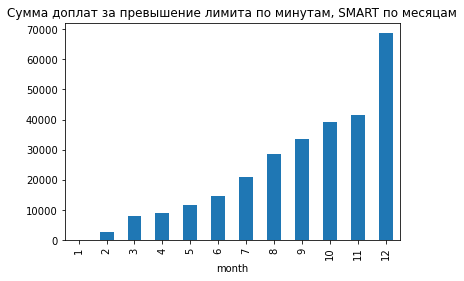

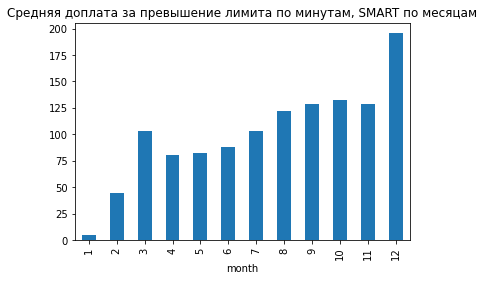

In [29]:
users_stat[users_stat['tariff'] == 'smart'].groupby('month')['pay_over_call'].sum().plot(y='pay_over_call', kind='bar')
plt.title('Сумма доплат за превышение лимита по минутам, SMART по месяцам')
plt.show()
users_stat[users_stat['tariff'] == 'smart'].groupby('month')['pay_over_call']. mean().plot(y='pay_over_call', kind='bar')
plt.title('Средняя доплата за превышение лимита по минутам, SMART по месяцам')
plt.show()

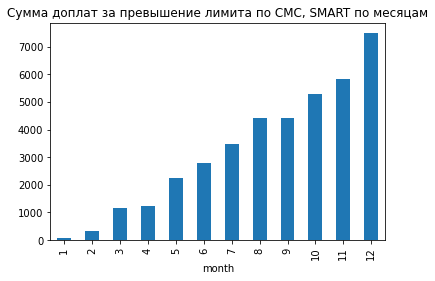

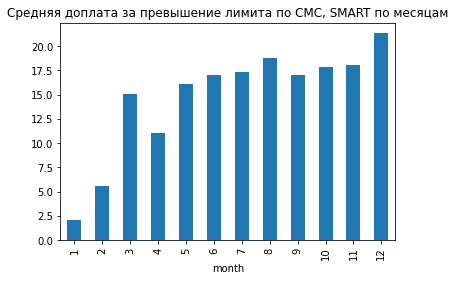

In [30]:
users_stat[users_stat['tariff'] == 'smart'].groupby('month')['pay_over_msg'].sum().plot(y='pay_over_msg', kind='bar')
plt.title('Сумма доплат за превышение лимита по СМС, SMART по месяцам')
plt.show()
users_stat[users_stat['tariff'] == 'smart'].groupby('month')['pay_over_msg']. mean().plot(y='pay_over_msg', kind='bar')
plt.title('Средняя доплата за превышение лимита по СМС, SMART по месяцам')
plt.show()

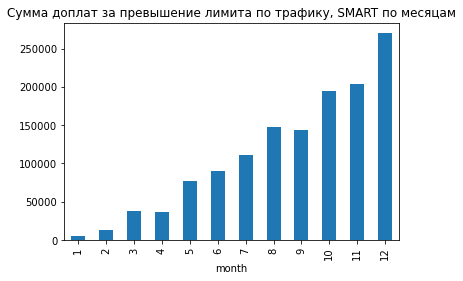

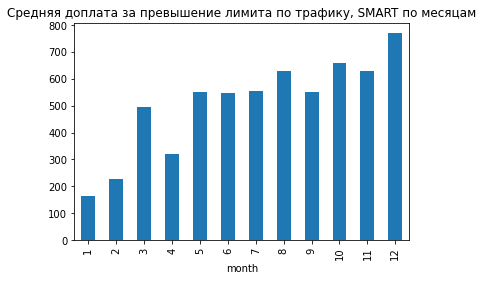

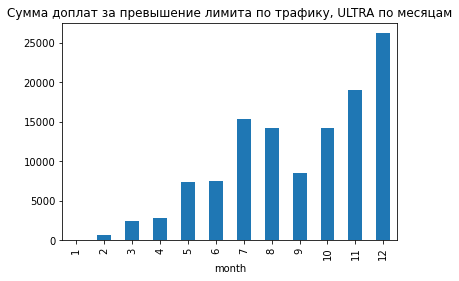

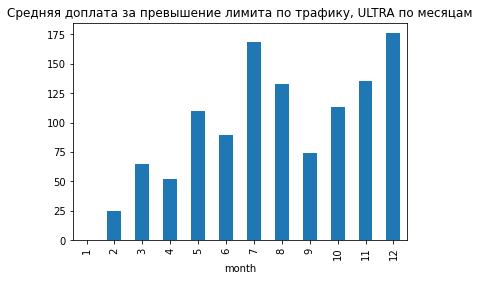

In [31]:
users_stat[users_stat['tariff'] == 'smart'].groupby('month')['pay_over_gb'].sum().plot(y='pay_over_gb', kind='bar')
plt.title('Сумма доплат за превышение лимита по трафику, SMART по месяцам')
plt.show()
users_stat[users_stat['tariff'] == 'smart'].groupby('month')['pay_over_gb']. mean().plot(y='pay_over_gb', kind='bar')
plt.title('Средняя доплата за превышение лимита по трафику, SMART по месяцам')
plt.show()

users_stat[users_stat['tariff'] == 'ultra'].groupby('month')['pay_over_gb'].sum().plot(y='pay_over_gb', kind='bar')
plt.title('Сумма доплат за превышение лимита по трафику, ULTRA по месяцам')
plt.show()
users_stat[users_stat['tariff'] == 'ultra'].groupby('month')['pay_over_gb']. mean().plot(y='pay_over_gb', kind='bar')
plt.title('Средняя доплата за превышение лимита по трафику, ULTRA по месяцам')
plt.show()

~ 30% пользователей предпочитают тариф ULTRA \
~ 58% выручки - оплата по тарифу SMART

*Пользователи тарифа ULTRA платят больше в расчете на одного человека в месяц, но пользователи тарифа SMART суммарно приносят больше выручки за счет количества - тариф SMART более популярный**

Обратим внимание:
* Средняя сумма оплаты по тарифу SMART увеличивается с течением времени
* Наибольшую сумму приносит дополнительная плата за превышение лимитов по интернет-трафику на тарифе SMART
* Пользователям тарифа SMART не хватает установленных лифитов - в 73.7% случаев оплат по этому тарифу происходит доплата за превышение лимитов
* На тарифе SMART дополнительная плата за интернет превышает оплату по тарифу
* Пользоваители тарифа ULTRA редко выходят за пределы лимитов тарифа, дополнительная плата составляет всего 5.6% от общей суммы оплат по тарифу
* СМС не очень интересны пользователям
* Подключается пользователей больше, чем отключается: в 6 раз на тарифе SMART и в 4 на тарифе ULTRA, но выборка пользователей очень мала, чтобы учитывать этот факт



## Опишите распределения 

**Суммы оплат**

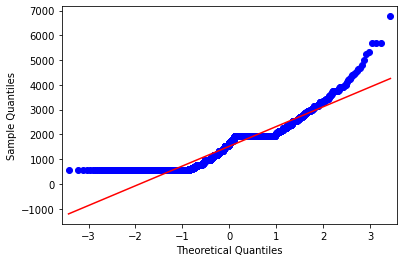

Тест Шапиро-Вилка: 0.8946509957313538 1.1840972023544704e-42
Тест дАгостино на K ^ 2: 366.9686929060091 2.059495369477105e-80
Тест Андерсона-Дарлинга: AndersonResult(statistic=102.2260867837249, critical_values=array([0.575, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


**Количество звонков**

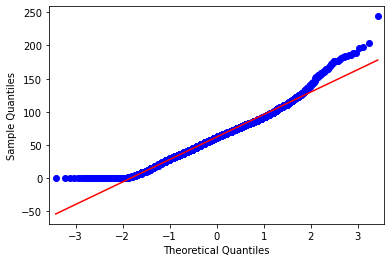

Тест Шапиро-Вилка: 0.9773352742195129 2.1789052594640114e-22
Тест дАгостино на K ^ 2: 205.2336737591296 2.7169021210855814e-45
Тест Андерсона-Дарлинга: AndersonResult(statistic=7.657342214210985, critical_values=array([0.575, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


**Длительность звонков**

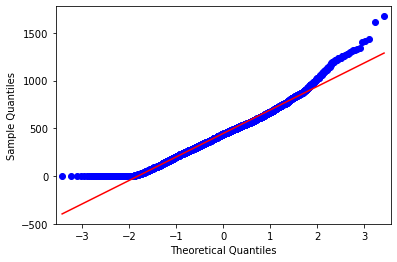

Тест Шапиро-Вилка: 0.9776208400726318 3.0001104715410434e-22
Тест дАгостино на K ^ 2: 200.13693916508092 3.47388828274574e-44
Тест Андерсона-Дарлинга: AndersonResult(statistic=7.856795332354977, critical_values=array([0.575, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


**Количество СМС**

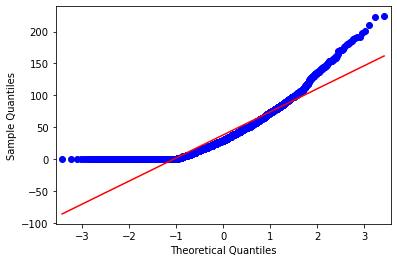

Тест Шапиро-Вилка: 0.8823569416999817 2.2420775429197073e-44
Тест дАгостино на K ^ 2: 720.4386637923377 3.620194319787676e-157
Тест Андерсона-Дарлинга: AndersonResult(statistic=89.8800074183664, critical_values=array([0.575, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


**Трафик**

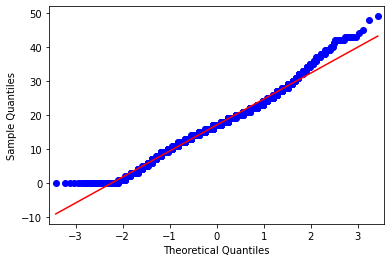

Тест Шапиро-Вилка: 0.9837378263473511 6.64344990791924e-19
Тест дАгостино на K ^ 2: 95.81059143281843 1.5667309270391462e-21
Тест Андерсона-Дарлинга: AndersonResult(statistic=12.689469861426915, critical_values=array([0.575, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


In [32]:
normalCheck(users_stat, 'pay_sum', .05, 'Суммы оплат')
normalCheck(users_stat, 'calls_cnt', .05, 'Количество звонков')
normalCheck(users_stat, 'calls_duration_sum', .05, 'Длительность звонков')
normalCheck(users_stat, 'messages_cnt', .05, 'Количество СМС')
normalCheck(users_stat, 'gb_used_sum', .05, 'Трафик')

## Проверка гипотез

In [33]:
alpha = 0.05

def CheckHypothesis(data1, data2,equal):
    results = stats.ttest_ind(data1,data2,
                          equal_var = equal )
    if results.pvalue < alpha:
        printmd("**Отвергаем нулевую гипотезу.** ")
    else:
        printmd("**Не получилось отвергнуть нулевую гипотезу.** ") 
    print('p-значение: ', results) 
    print()

In [34]:
print('H0: Cредняя выручка пользователей тарифов «Ультра» и «Смарт» равны')
print('H1: Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различаются')
print()
print('Так как параметры совокупностей разные, проставим equal_var = False')

CheckHypothesis(users_stat[users_stat['tariff'] == 'smart']['pay_sum'],
                users_stat[users_stat['tariff'] == 'ultra']['pay_sum'],
                False)


H0: Cредняя выручка пользователей тарифов «Ультра» и «Смарт» равны
H1: Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Так как параметры совокупностей разные, проставим equal_var = False


**Отвергаем нулевую гипотезу.** 

p-значение:  Ttest_indResult(statistic=-37.67706881767835, pvalue=3.6959751806665007e-258)



In [35]:
print('H0: Cредняя выручка от пользователей из Москвы и выручка от пользователей других регионов равны')
print('H1: Cредняя выручка от пользователей из Москвы и выручка от пользователей других регионов различаются')
print()
print('Так как параметры совокупностей разные, проставим equal_var = False')
CheckHypothesis(users_stat[users_stat['city'] == 'москва']['pay_sum'],
                users_stat[users_stat['city'] != 'москва']['pay_sum'],
                False)

H0: Cредняя выручка от пользователей из Москвы и выручка от пользователей других регионов равны
H1: Cредняя выручка от пользователей из Москвы и выручка от пользователей других регионов различаются

Так как параметры совокупностей разные, проставим equal_var = False


**Не получилось отвергнуть нулевую гипотезу.** 

p-значение:  Ttest_indResult(statistic=0.8034270065320763, pvalue=0.42192271461069386)



Ради интереса посмотрим на доплаты по звонкам, смс и интернету по отдельности

In [36]:
print('H0: Cредняя доплата за превышение лимита по минутам пользователей тарифов «Ультра» и «Смарт» равны')
print('H1: Cредняя доплата за превышение лимита по минутам пользователей тарифов «Ультра» и «Смарт» различаются')
CheckHypothesis(users_stat[users_stat['tariff'] == 'smart']['pay_over_call'],
                users_stat[users_stat['tariff'] == 'ultra']['pay_over_call'],
                False)

print('H0: Cредняя доплата за превышение лимита по СМС пользователей тарифов «Ультра» и «Смарт» равны')
print('H1: Cредняя доплата за превышение лимита по СМС пользователей тарифов «Ультра» и «Смарт» различаются')
CheckHypothesis(users_stat[users_stat['tariff'] == 'smart']['pay_over_msg'],
                users_stat[users_stat['tariff'] == 'ultra']['pay_over_msg'],
                False)

print('H0: Cредняя доплата за превышение лимита по Gb пользователей тарифов «Ультра» и «Смарт» равны')
print('H1: Cредняя доплата за превышение лимита по Gb пользователей тарифов «Ультра» и «Смарт» различаются')
CheckHypothesis(users_stat[users_stat['tariff'] == 'smart']['pay_over_gb'],
                users_stat[users_stat['tariff'] == 'ultra']['pay_over_gb'],
                False)

print('H0: Cредняя доплата за превышение лимита по минутам от пользователей из Москвы и от пользователей других регионов равны')
print('H1: Cредняя доплата за превышение лимита по минутам от пользователей из Москвы и от пользователей других регионов различаются')
CheckHypothesis(users_stat[users_stat['city'] == 'москва']['pay_over_call'],
                users_stat[users_stat['city'] != 'москва']['pay_over_call'],
                False)

print('H0: Cредняя доплата за превышение лимита по СМС от пользователей из Москвы и от пользователей других регионов равны')
print('H1: Cредняя доплата за превышение лимита по СМС от пользователей из Москвы и от пользователей других регионов различаются')
CheckHypothesis(users_stat[users_stat['city'] == 'москва']['pay_over_msg'],
                users_stat[users_stat['city'] != 'москва']['pay_over_msg'],
                False)

print('H0: Cредняя доплата за превышение лимита по Gb от пользователей из Москвы и от пользователей других регионов равны')
print('H1: Cредняя доплата за превышение лимита по Gb от пользователей из Москвы и от пользователей других регионов различаются')
CheckHypothesis(users_stat[users_stat['city'] == 'москва']['pay_over_gb'],
                users_stat[users_stat['city'] != 'москва']['pay_over_gb'],
                False)

H0: Cредняя доплата за превышение лимита по минутам пользователей тарифов «Ультра» и «Смарт» равны
H1: Cредняя доплата за превышение лимита по минутам пользователей тарифов «Ультра» и «Смарт» различаются


**Отвергаем нулевую гипотезу.** 

p-значение:  Ttest_indResult(statistic=23.167380369160608, pvalue=1.1152808804973865e-106)

H0: Cредняя доплата за превышение лимита по СМС пользователей тарифов «Ультра» и «Смарт» равны
H1: Cредняя доплата за превышение лимита по СМС пользователей тарифов «Ультра» и «Смарт» различаются


**Отвергаем нулевую гипотезу.** 

p-значение:  Ttest_indResult(statistic=20.35018408759281, pvalue=1.1983244960905136e-84)

H0: Cредняя доплата за превышение лимита по Gb пользователей тарифов «Ультра» и «Смарт» равны
H1: Cредняя доплата за превышение лимита по Gb пользователей тарифов «Ультра» и «Смарт» различаются


**Отвергаем нулевую гипотезу.** 

p-значение:  Ttest_indResult(statistic=24.368929851630256, pvalue=1.7296482110375885e-120)

H0: Cредняя доплата за превышение лимита по минутам от пользователей из Москвы и от пользователей других регионов равны
H1: Cредняя доплата за превышение лимита по минутам от пользователей из Москвы и от пользователей других регионов различаются


**Не получилось отвергнуть нулевую гипотезу.** 

p-значение:  Ttest_indResult(statistic=-1.594888590710278, pvalue=0.11103871965501119)

H0: Cредняя доплата за превышение лимита по СМС от пользователей из Москвы и от пользователей других регионов равны
H1: Cредняя доплата за превышение лимита по СМС от пользователей из Москвы и от пользователей других регионов различаются


**Отвергаем нулевую гипотезу.** 

p-значение:  Ttest_indResult(statistic=-4.395290760599562, pvalue=1.2001374231388463e-05)

H0: Cредняя доплата за превышение лимита по Gb от пользователей из Москвы и от пользователей других регионов равны
H1: Cредняя доплата за превышение лимита по Gb от пользователей из Москвы и от пользователей других регионов различаются


**Отвергаем нулевую гипотезу.** 

p-значение:  Ttest_indResult(statistic=-2.2034771162733007, pvalue=0.027786695557006195)



# Общий вывод

Тариф SMART является более популярным среди пользователей, приносит больше выручки за счет количества пользователей и условий тарифа - пользователи часто не укладываются в лимиты тарифа, особенно по трафику.

~ 30% пользователей предпочитают тариф ULTRA, остальные - **70% SMART**
~ **58% выручки - оплата по тарифу SMART**, при этом **~48% из них поступает за превышение лимита по трафику**, ~42% - оплата ежемесячнойго платежа, ~10% - доплата за превышение лимита по минутам.

Обратим внимание:
* Средняя сумма оплаты по тарифу SMART увеличивается с течением времени
* Наибольшую сумму приносит дополнительная плата за превышение лимитов по интернет-трафику на тарифе SMART
* Пользователям тарифа SMART не хватает установленных лимитов - в 73.7% случаев оплат по этому тарифу происходит доплата за превышение
* На тарифе SMART дополнительная плата за интернет превышает оплату по тарифу (48% против 42% от выручки по тарифу)
* Пользоваители тарифа ULTRA редко выходят за пределы лимитов тарифа, дополнительная плата составляет всего 5.6% от общей суммы оплат по тарифу
* СМС не очень интересны пользователям
* Подключается пользователей больше, чем отключается: в 6 раз на тарифе SMART и в 4 на тарифе ULTRA, но выборка пользователей очень мала, чтобы учитывать этот факт
* Не стоит забывать и про то, что большее количество пользователей несет большее количество затрат для оператора - на оборудование, поддержку и т.д., а в данном исследовании затраты на обслуживание не учитывались

Скорректировать рекламный бюджет можно в сторону увеличения на тариф SMART. 